# Habitable Exoplanets
We're using the dataset of confirmed exoplanets from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag%20%3E0) to find potentially habitable exoplanets. Habitability in our case is only determined basically by the planet having a temperature where liquid water could exist on the surface. Column definitions are found [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
sns.set_theme(style="whitegrid")

In [2]:
planets = pd.read_csv('exoplanets.csv', header=98)
planets.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
2,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2022-09-19,2022-09,2022-09-19
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603,2018-09-04,2017-03,2018-09-06


[]

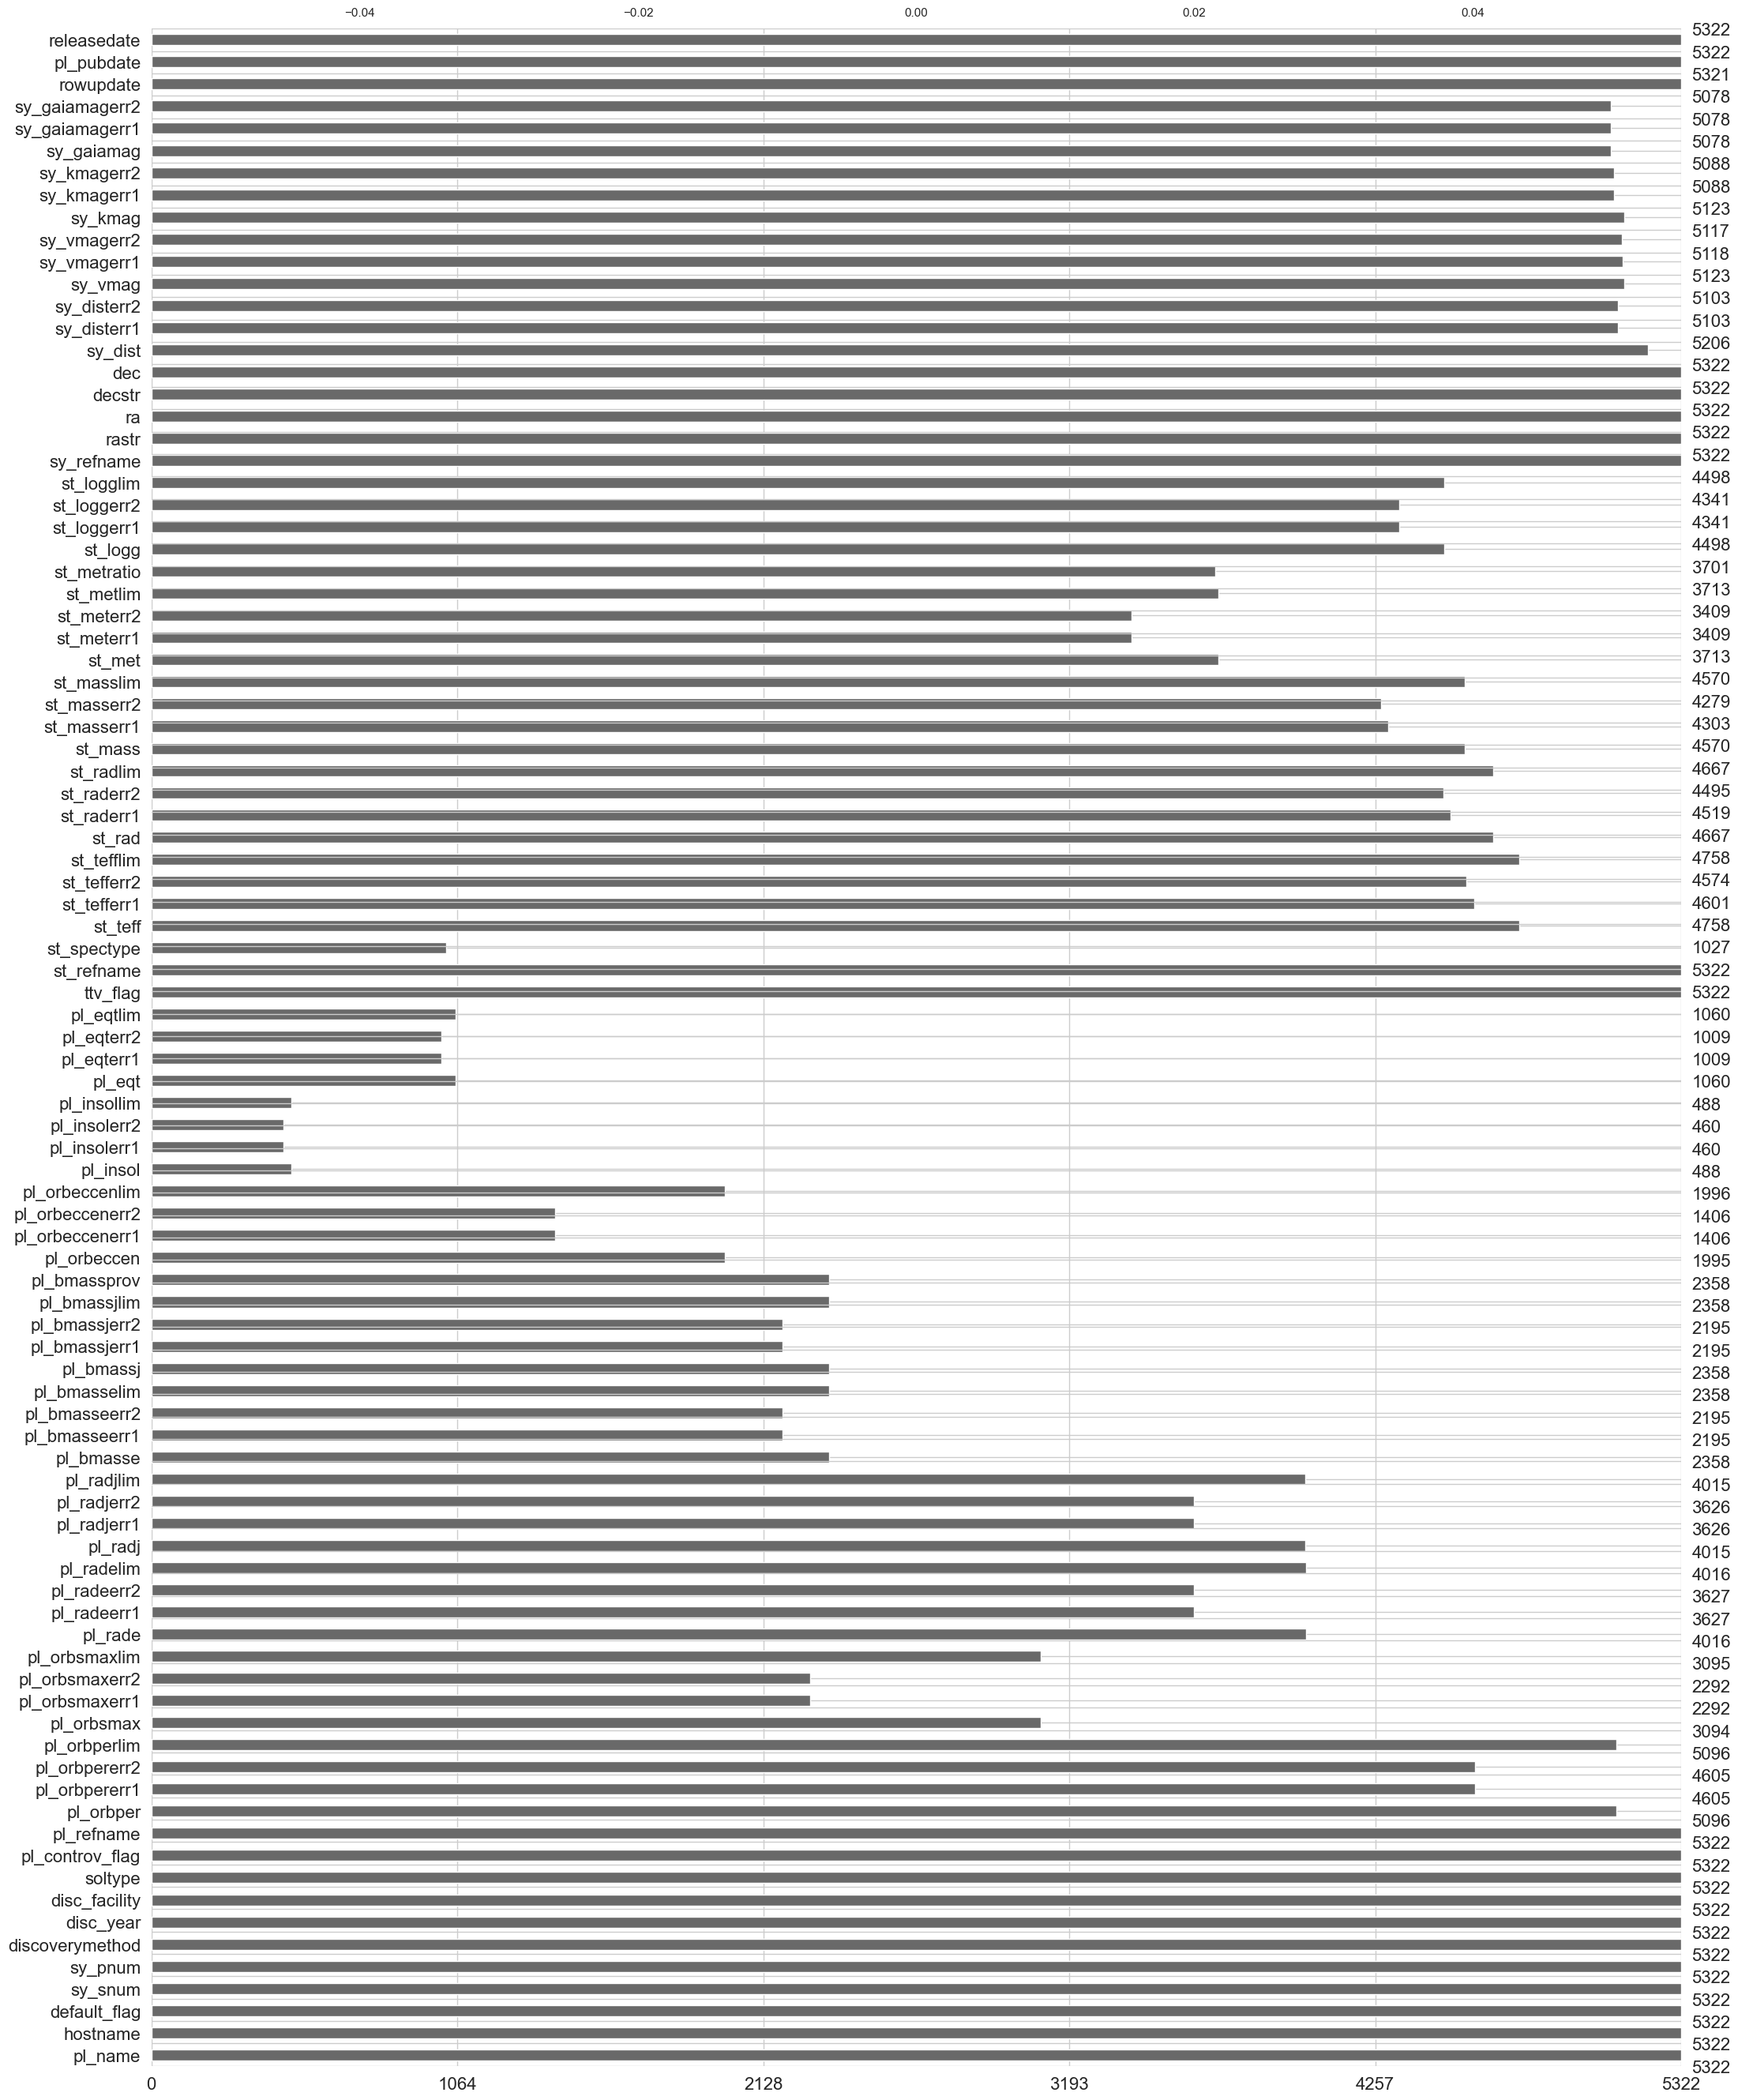

In [3]:
# look at missing data for each column
msno.bar(planets)
plt.plot()

In [4]:
# here I'm just grabbing columns which seem to have a decent amount of data and/or could be interesting to analyze later
hab_cols = ['pl_name', 'discoverymethod','pl_orbsmax','pl_eqt', 'pl_insol', 'pl_bmasse', 'pl_rade', 'pl_orbper', 
            'hostname', 'st_teff', 'st_rad', 'st_logg', 'st_met', 'st_mass', 'sy_pnum', 'sy_snum']
hab = planets[hab_cols]
hab.head()

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum
0,11 Com b,Radial Velocity,1.290000,NaN,NaN,6165.60000,NaN,326.030000,11 Com,4742.0,19.00,2.31,-0.35,2.70,1,2
1,11 UMi b,Radial Velocity,1.530000,NaN,NaN,4684.81420,NaN,516.219970,11 UMi,4213.0,29.79,1.93,-0.02,2.78,1,1
2,14 And b,Radial Velocity,0.830000,NaN,NaN,1525.50000,NaN,185.840000,14 And,4813.0,11.00,2.63,-0.24,2.20,1,1
3,14 Her b,Radial Velocity,2.773069,NaN,NaN,2586.74645,NaN,1765.038901,14 Her,NaN,NaN,NaN,NaN,0.91,2,1
4,16 Cyg B b,Radial Velocity,1.660000,NaN,NaN,565.73740,NaN,798.500000,16 Cyg B,5750.0,1.13,4.36,0.06,1.08,1,3


In [5]:
display(hab.isna().sum())
print("Total planets: ", len(hab))

pl_name               0
discoverymethod       0
pl_orbsmax         2228
pl_eqt             4262
pl_insol           4834
pl_bmasse          2964
pl_rade            1306
pl_orbper           226
hostname              0
st_teff             564
st_rad              655
st_logg             824
st_met             1609
st_mass             752
sy_pnum               0
sy_snum               0
dtype: int64

Total planets:  5322


In [6]:
# get number of rows with each type of discovery method
hab['discoverymethod'].value_counts()

discoverymethod
Transit                          3982
Radial Velocity                  1032
Microlensing                      181
Imaging                            64
Transit Timing Variations          25
Eclipse Timing Variations          17
Orbital Brightness Modulation       9
Pulsar Timing                       7
Astrometry                          2
Pulsation Timing Variations         2
Disk Kinematics                     1
Name: count, dtype: int64

In [7]:
# using the formula found here https://www.astro.princeton.edu/~strauss/FRS113/writeup3/
# takes into account the size and temperature of the star as well as how far away from the star the planet is
def calcTemp(st_temp, st_rad, sma):
    sunRadius = 695700
    st_rad = st_rad * sunRadius
    au = 1.5e8
    sma = sma * au
    albedo = 0.3
    pl_temp = st_temp * ((1-albedo)**0.25) * ((st_rad/(2*sma))**0.5)
    return pl_temp

In [8]:
# create calculated temperature column
hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])

C:\Users\a02296155\AppData\Local\Temp\ipykernel_22796\865229821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])


In [9]:
# look at rows without missing values for pl_eqt and pl_calc_temp
hab[hab['pl_eqt'].notna() & hab['pl_calc_temp'].notna()].head()

# a bit different for pl_eqt and pl_calc_temp, maybe units are different?

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum,pl_calc_temp
11,2M0437 b,Imaging,118.0000,1450.0,NaN,1271.31363,NaN,NaN,2MASS J04372171+2651014,3100.0,0.84,4.50,0.01,0.17,1,1,11.520868
45,AF Lep b,Imaging,7.9900,1400.0,NaN,1664.46737,NaN,7.520000e+03,AF Lep,6100.0,1.25,4.40,NaN,1.20,1,1,106.276278
61,BD+60 1417 b,Imaging,1662.0000,1303.0,NaN,4767.42610,14.684,NaN,BD+60 1417,4993.0,0.80,4.55,NaN,1.00,1,1,4.825207
73,CD Cet b,Radial Velocity,0.0185,464.0,8.6,3.95000,NaN,2.290700e+00,CD Cet,3130.0,0.17,4.93,0.13,0.16,1,1,417.934110
75,CFHTWIR-Oph 98 b,Imaging,200.0000,1800.0,NaN,2479.06157,20.849,8.040000e+06,CFHTWIR-Oph 98 A,2320.0,0.24,3.85,NaN,0.01,1,1,3.540002


In [10]:
# check habitability (potential) based off of pl_eqt or pl_insol (implement pl_calc_temp once unit stuff confirmed)
hab['habitable'] = ((hab['pl_eqt'] > 180) & (hab['pl_eqt'] < 310)) | ((hab['pl_insol'] > 0.25) & (hab['pl_insol'] < 2.2))

C:\Users\a02296155\AppData\Local\Temp\ipykernel_22796\3798843424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['habitable'] = ((hab['pl_eqt'] > 180) & (hab['pl_eqt'] < 310)) | ((hab['pl_insol'] > 0.25) & (hab['pl_insol'] < 2.2))


In [11]:
# should be getting close to their number, like 360
hab['habitable'].sum()

71

# Finding Best Classification
We're going to use pycaret to try and quickly find the best model for classifying habitable exoplanets. This will include using the calculated temperature range, as well as only using **confirmed** exoplanets.

In [12]:
# creating function to apply to each row to calculate habitable column based on pl_calc_temp for planets without pl_eqt

def calc_habitable(row):
    habitable_temp = 0
    habitable_insol = 0

    # check if pl_eqt is not missing and if in habitable range
    if (not np.isnan(row['pl_eqt'])):
        habitable_temp = ((row['pl_eqt'] > 180) & (row['pl_eqt'] < 310))

    # check if pl_insol is not missing and if in habitable range
    if (not np.isnan(row['pl_insol'])):
        habitable_insol = ((row['pl_insol'] > 0.25) & (row['pl_insol'] < 2.2))

    # if pl_eqt is missing, check if pl_calc_temp is in habitable range
    if (np.isnan(row['pl_eqt'])):
        habitable_temp = ((row['pl_calc_temp'] > 180) & (row['pl_calc_temp'] < 310))

    return habitable_temp | habitable_insol



In [13]:
# apply function to each row
hab['habitable'] = hab.apply(calc_habitable, axis=1)
hab['habitable'].sum()

C:\Users\a02296155\AppData\Local\Temp\ipykernel_22796\1532112116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['habitable'] = hab.apply(calc_habitable, axis=1)


190

In [14]:
# look at percentage of data missing for each column
hab_na_pct = hab.isna().sum() / len(hab)
hab_na_pct

pl_name            0.000000
discoverymethod    0.000000
pl_orbsmax         0.418640
pl_eqt             0.800827
pl_insol           0.908305
pl_bmasse          0.556933
pl_rade            0.245396
pl_orbper          0.042465
hostname           0.000000
st_teff            0.105975
st_rad             0.123074
st_logg            0.154829
st_met             0.302330
st_mass            0.141300
sy_pnum            0.000000
sy_snum            0.000000
pl_calc_temp       0.541526
habitable          0.000000
dtype: float64

In [15]:
# check how many rows are left when removing rows with missing values
hab.dropna().shape

# look at how many of those are habitable
hab.dropna()['habitable'].sum()


7

In [16]:
# save subset of data of columns with less than 90% missing values
hab_subset = hab.dropna(axis=1, thresh=len(hab) * 0.9)
display(hab_subset.columns)
hab_subset.dropna().shape

Index(['pl_name', 'discoverymethod', 'pl_orbper', 'hostname', 'sy_pnum',
       'sy_snum', 'habitable'],
      dtype='object')

(5096, 7)

In [17]:
# look at how many of those are habitable
hab_subset.dropna()['habitable'].sum()
# that is all the habitable included

190

In [18]:
# instead, first pull out dataframe with only habitable exoplanets
hab_true = hab[hab['habitable'] == True]

# find which columns have less than 90% missing values
hab_true_na_pct = hab_true.isna().sum() / len(hab_true)

hab_true_subset = hab_true.dropna(axis=1, thresh=len(hab_true) * 0.9)
display(hab_true_subset.columns)
hab_true_subset.dropna().shape

Index(['pl_name', 'discoverymethod', 'pl_orbsmax', 'pl_orbper', 'hostname',
       'st_teff', 'st_rad', 'st_mass', 'sy_pnum', 'sy_snum', 'pl_calc_temp',
       'habitable'],
      dtype='object')

(175, 12)

In [19]:
# use these columns to subset the original dataframe, then build X and y data from that, then remove cols that don't make sense
hab_true_subset_cols = list(hab_true_subset.columns)

# keep habitable in so that indices match up for y, then remove useless columns and target variable
X = hab[hab_true_subset_cols].dropna()
y = X['habitable'].astype('int')

X = X.drop(columns=['habitable', 'pl_name', 'hostname', 'pl_calc_temp'])
X = pd.get_dummies(X, columns=['discoverymethod'], prefix='dm')

In [20]:
# use pycaret to find best model
# from pycaret.classification import *
# exp_clf = setup(data=X, target='habitable', session_id=123, silent=True)
# best_model = compare_models()

In [21]:
# use gridsearchcv to find best random forest classifier of habitable exoplanets
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 7, n_jobs=-1)
cv_rfc.fit(X, y)
print("best model accuracy: ", cv_rfc.best_score_)
print("best model params: ", cv_rfc.best_params_)

best model accuracy:  0.9405393000573724
best model params:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}


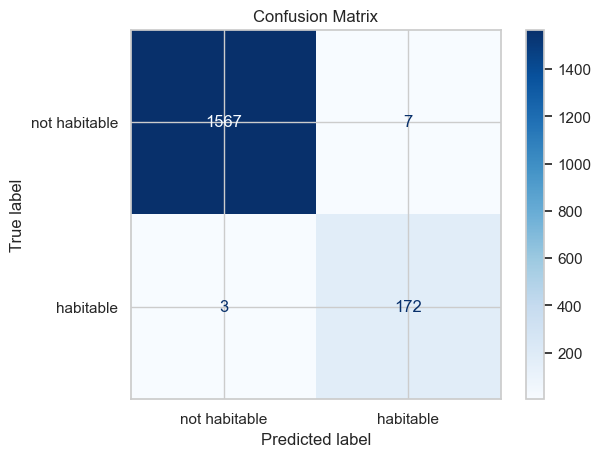

In [22]:
# look at confusion matrix for best model
y_pred = cv_rfc.predict(X)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not habitable', 'habitable'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [23]:
# get the feature importances from best model and combine in df with the feature names
feature_importances = pd.DataFrame(cv_rfc.best_estimator_.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
pl_orbper,0.288962
pl_orbsmax,0.237576
st_rad,0.141072
st_teff,0.133832
st_mass,0.110266
dm_Transit,0.026406
dm_Radial Velocity,0.025935
sy_pnum,0.021849
sy_snum,0.008986
dm_Transit Timing Variations,0.003736


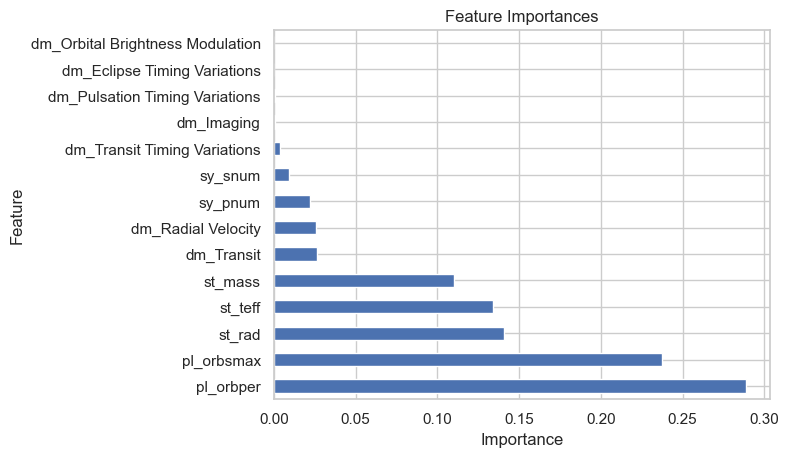

In [24]:
# plot the feature importances
feature_importances.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend().remove()
plt.show()

In [25]:
# use the top 5 features and find best cv model
X_top5 = X[feature_importances.index[:5]]
cv_rfc_top5 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 7, n_jobs=-1)
cv_rfc_top5.fit(X_top5, y)
print("best model accuracy: ", cv_rfc_top5.best_score_)
print("best model params: ", cv_rfc_top5.best_params_)

best model accuracy:  0.9594170969592655
best model params:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


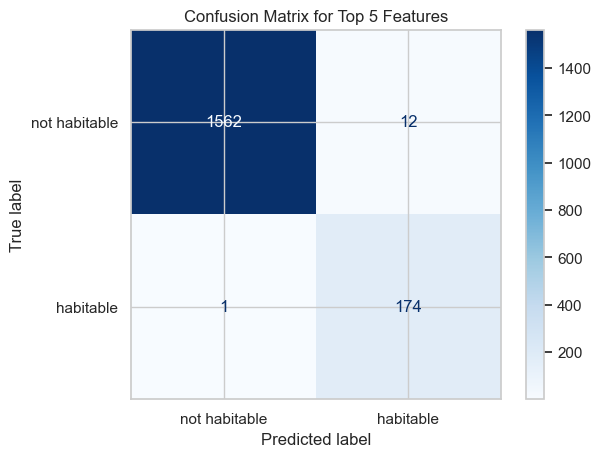

In [26]:
# look at confusion matrix for best model
y_pred_top5 = cv_rfc_top5.predict(X_top5)
cm_top5 = confusion_matrix(y, y_pred_top5)
disp_top5 = ConfusionMatrixDisplay(confusion_matrix=cm_top5, display_labels=['not habitable', 'habitable'], )
disp_top5.plot(cmap='Blues')
plt.title('Confusion Matrix for Top 5 Features')
plt.show()

In [27]:
# relook at what these features are and their importance in the new model
feature_importances_top5 = pd.DataFrame(cv_rfc_top5.best_estimator_.feature_importances_,
                                   index = X_top5.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_top5

,importance
pl_orbper,0.344788
pl_orbsmax,0.232562
st_rad,0.177457
st_teff,0.131348
st_mass,0.113846


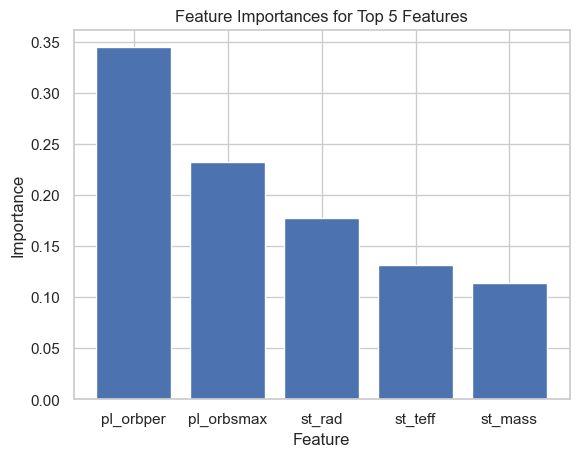

In [28]:
# plot feature importances
plt.bar(feature_importances_top5.index, feature_importances_top5['importance'])
plt.title('Feature Importances for Top 5 Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

### Future Ideas
* Look at seeing if there are trends in stars that have habitable exoplanets to try and find stars to look for exoplanets
* try imputing data
* take out habitable exoplanets, compare stats to unhabitable exoplanets
* lots of plots and visualizations